# Đọc và tiền xử lí dữ liệu

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Load the stock data
df = pd.read_csv('ACB Historical Data.csv', index_col='Date', parse_dates=True)

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
2017-12-04,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2017-12-05,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
2017-12-06,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
2017-12-07,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
2023-06-12,21450.0,21650.0,21650.0,21350.0,4290000,-0.0046
2023-06-13,21600.0,21500.0,21600.0,21400.0,7970000,0.0070
2023-06-14,21650.0,21650.0,21900.0,21600.0,8029999,0.0023


# Phân chia dữ liệu

In [2]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

# Xây dựng mô hình và train

In [4]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 56ms/step - loss: 0.0987 - val_loss: 0.0647
Epoch 2/100
14/14 [==============================] - 0s 29ms/step - loss: 0.0302 - val_loss: 0.0150
Epoch 3/100
14/14 [==============================] - 0s 28ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 4/100
14/14 [==============================] - 0s 29ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 5/100
14/14 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 6/100
14/14 [==============================] - 0s 28ms/step - loss: 7.5132e-04 - val_loss: 0.0017
Epoch 7/100
14/14 [==============================] - 0s 30ms/step - loss: 7.3584e-04 - val_loss: 0.0024
Epoch 8/100
14/14 [==============================] - 0s 28ms/step - loss: 6.4380e-04 - val_loss: 0.0017
Epoch 9/100
14/14 [==============================] - 0s 29ms/step - loss: 6.2584e-04 - val_loss: 0.0019
Epoch 10/100
14/14 [==============================] - 1s 37ms/step - loss: 6.0700e-0

# Dự báo trên tập test / validate và đánh giá mô hình

In [5]:
# 10. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

2/2 [==============================] - 0s 7ms/step


In [6]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_score_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_score_mda = calculate_mda(y_test, y_pred)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 23963.460311906474
MAPE trên tập test là: 3466910.362911399 %
MDA trên tập test là: 0.0 %


C:\Users\tonnu\AppData\Local\Temp\ipykernel_19160\2915914690.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)


# Dự báo 30 ngày tiếp theo

In [7]:
x_input=val_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.6062188]
80
1 day input [0.73329506 0.71708903 0.72403447 0.75876167 0.75413138 0.72866476
 0.71940417 0.72866476 0.75181623 0.76802226 0.74718594 0.72866476
 0.70782844 0.74255564 0.72403447 0.72171932 0.70551329 0.71477388
 0.71245873 0.72866476 0.73097991 0.72634961 0.72634961 0.72403447
 0.73329506 0.75181623 0.76339197 0.75876167 0.76570712 0.74718594
 0.75413138 0.75181623 0.74950109 0.74487079 0.74950109 0.74950109
 0.75181623 0.7402405  0.72403447 0.71708903 0.71708903 0.71477388
 0.71245873 0.71245873 0.71245873 0.71477388 0.73792535 0.7356102
 0.74950109 0.74718594 0.74718594 0.74718594 0.75181623 0.75181623
 0.75181623 0.74718594 0.75181623 0.74950109 0.75413138 0.76802226
 0.75876167 0.75644653 0.75181623 0.75876167 0.76107682 0.77033741
 0.58512564 0.60364682 0.60133167 0.60364682 0.60596197 0.59438623
 0.59207108 0.58744079 0.59438623 0.59670138 0.59901653 0.60364682
 0.60621881]
1 day output [[0.6095366]]
2 day input [0.71708903 0.72403447 0.75876167 0.75413138 0.7286

10 day output [[0.63802564]]
11 day input [0.74718594 0.72866476 0.70782844 0.74255564 0.72403447 0.72171932
 0.70551329 0.71477388 0.71245873 0.72866476 0.73097991 0.72634961
 0.72634961 0.72403447 0.73329506 0.75181623 0.76339197 0.75876167
 0.76570712 0.74718594 0.75413138 0.75181623 0.74950109 0.74487079
 0.74950109 0.74950109 0.75181623 0.7402405  0.72403447 0.71708903
 0.71708903 0.71477388 0.71245873 0.71245873 0.71245873 0.71477388
 0.73792535 0.7356102  0.74950109 0.74718594 0.74718594 0.74718594
 0.75181623 0.75181623 0.75181623 0.74718594 0.75181623 0.74950109
 0.75413138 0.76802226 0.75876167 0.75644653 0.75181623 0.75876167
 0.76107682 0.77033741 0.58512564 0.60364682 0.60133167 0.60364682
 0.60596197 0.59438623 0.59207108 0.58744079 0.59438623 0.59670138
 0.59901653 0.60364682 0.60621881 0.60953659 0.61273658 0.61592942
 0.6191172  0.62229729 0.6254679  0.62862736 0.63177413 0.63490725
 0.63802564]
11 day output [[0.6411286]]
12 day input [0.72866476 0.70782844 0.74255564

20 day output [[0.6682631]]
21 day input [0.73097991 0.72634961 0.72634961 0.72403447 0.73329506 0.75181623
 0.76339197 0.75876167 0.76570712 0.74718594 0.75413138 0.75181623
 0.74950109 0.74487079 0.74950109 0.74950109 0.75181623 0.7402405
 0.72403447 0.71708903 0.71708903 0.71477388 0.71245873 0.71245873
 0.71245873 0.71477388 0.73792535 0.7356102  0.74950109 0.74718594
 0.74718594 0.74718594 0.75181623 0.75181623 0.75181623 0.74718594
 0.75181623 0.74950109 0.75413138 0.76802226 0.75876167 0.75644653
 0.75181623 0.75876167 0.76107682 0.77033741 0.58512564 0.60364682
 0.60133167 0.60364682 0.60596197 0.59438623 0.59207108 0.58744079
 0.59438623 0.59670138 0.59901653 0.60364682 0.60621881 0.60953659
 0.61273658 0.61592942 0.6191172  0.62229729 0.6254679  0.62862736
 0.63177413 0.63490725 0.63802564 0.6411286  0.64421558 0.6472857
 0.65033841 0.65337324 0.65638983 0.65938741 0.66236579 0.66532445
 0.66826308]
21 day output [[0.6711811]]
22 day input [0.72634961 0.72634961 0.72403447 0.

# Vẽ đồ thị

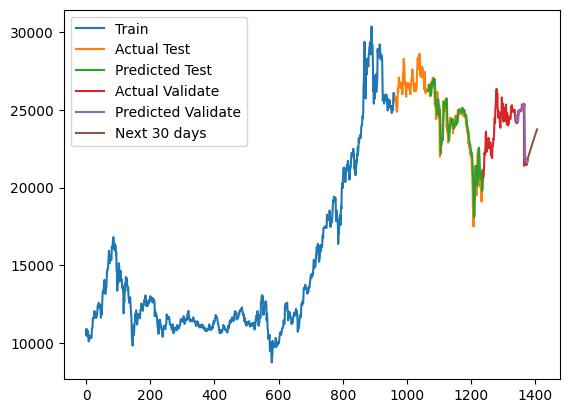

In [8]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Actual Test','Predicted Test','Actual Validate','Predicted Validate','Next 30 days'])
plt.show()